# Bounding Box Detection Training with YOLO

This file was created and ran with Google Colab. Some issues may arise if attempted to run locally.

### Imports

In [ ]:
import os
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython import display

import torch
import ultralytics
from ultralytics import YOLO
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, auc
from scipy.interpolate import make_interp_spline
import shutil
from pathlib import Path
from PIL import Image

import albumentations as A
from albumentations.pytorch import ToTensorV2

from google.colab import drive

HOME = os.getcwd()
display.clear_output()
ultralytics.checks()

Ultralytics YOLOv8.2.103 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 35.0/112.6 GB disk)


In [ ]:
drive.mount('/content/drive')
annotations_folder = r"/content/drive/My Drive/cct20/cct20/annotations"  # Correct path
image_folder=r"/content/drive/My Drive/cct20/cct20/Unseen_images_2"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Loading and Treating CCT20

In [ ]:
json_files = [f for f in os.listdir(annotations_folder) if f.endswith('.json')]
all_data = []
category_mapping = {}

for file in json_files:
    file_path = os.path.join(annotations_folder, file)
    with open(file_path, 'r') as f:
        data = json.load(f)

        for category in data['categories']:
            category_mapping[category['id']] = category['name']

        image_id_to_info = {}
        for img in data['images']:
            image_id_to_info[img['id']] = {
                'file_name': img['file_name'],
                'width': int(img['width'] / 2),
                'height': int(img['height'] / 2)
            }

        for ann in data['annotations']:
            if ann['image_id'] in image_id_to_info:
                image_info = image_id_to_info[ann['image_id']]
                # if ann['category_id'] != 30:
                all_data.append({
                    'annotation_id': ann['id'],
                    'image_id': image_info['file_name'],
                    'category_id': ann['category_id'],
                    'category_name': category_mapping[ann['category_id']],
                    'bbox': ann.get('bbox', None),
                    'image_width': image_info['width'],
                    'image_height': image_info['height']
                })

dataset_df = pd.DataFrame(all_data).set_index('annotation_id')

In [26]:
dataset_df = dataset_df.query('bbox.notna()')

In [ ]:
def scale_bbox(bbox):
    """Scales bounding box coordinates by a factor of 0.5 in both dimensions."""
    x_min, y_min, w, h = bbox

    # Scale coordinates to match downsized images
    x_min_scaled = int(x_min / 2)
    y_min_scaled = int(y_min / 2)
    w_scaled = int(w / 2)
    h_scaled = int(h / 2)

    return [x_min_scaled, y_min_scaled, w_scaled, h_scaled]

In [28]:
dataset_df['bbox']= dataset_df['bbox'].apply(scale_bbox)

In [29]:
print(dataset_df.head(-15))

                                               image_id  category_id  \
annotation_id                                                          
19688          5a197af2-23d2-11e8-a6a3-ec086b02610b.jpg           10   
43259          59fc7e52-23d2-11e8-a6a3-ec086b02610b.jpg           16   
10268          5a2e130d-23d2-11e8-a6a3-ec086b02610b.jpg           10   
2721           598ad0cf-23d2-11e8-a6a3-ec086b02610b.jpg            8   
2722           598ad0cf-23d2-11e8-a6a3-ec086b02610b.jpg            8   
...                                                 ...          ...   
15651          59452d91-23d2-11e8-a6a3-ec086b02610b.jpg            1   
10825          59167c07-23d2-11e8-a6a3-ec086b02610b.jpg            1   
35002          586adf11-23d2-11e8-a6a3-ec086b02610b.jpg            1   
14109          58643501-23d2-11e8-a6a3-ec086b02610b.jpg            9   
36538          586fdd2d-23d2-11e8-a6a3-ec086b02610b.jpg            1   

              category_name                  bbox  image_width 

In [ ]:
print(dataset_df['image_height'].value_counts())
print(dataset_df['image_width'].value_counts())
print(dataset_df['category_id'].value_counts())

image_height
747    43172
768     3530
960     1401
Name: count, dtype: int64
image_width
1024    46702
1280     1401
Name: count, dtype: int64
category_id
1     11970
3      7076
10     4995
9      4700
6      4320
16     4303
8      2641
33     2613
5      2479
11     1579
7       722
99      482
34      186
21       29
51        8
Name: count, dtype: int64


In [31]:
print(dataset_df['category_name'].unique())

['rabbit' 'cat' 'dog' 'opossum' 'squirrel' 'raccoon' 'coyote' 'rodent' 'bird' 'bobcat' 'skunk' 'badger' 'car' 'fox' 'deer']


In [ ]:
train_df, test_df = train_test_split(dataset_df, test_size=0.001, stratify=dataset_df['category_name'], random_state=31)
train_df, val_df = train_test_split(train_df, test_size=0.25, stratify=train_df['category_name'], random_state=37)

# Save train and test splits
train_df.to_csv("train_annotations.csv", index=False)
val_df.to_csv("val_annotations.csv", index=False)
test_df.to_csv("test_annotations.csv", index=False)

print("Train set size:", train_df.shape[0])
print("Validation set size:", val_df.shape[0])
print("Test set size:", test_df.shape[0])

Train set size: 36040
Validation set size: 12014
Test set size: 49


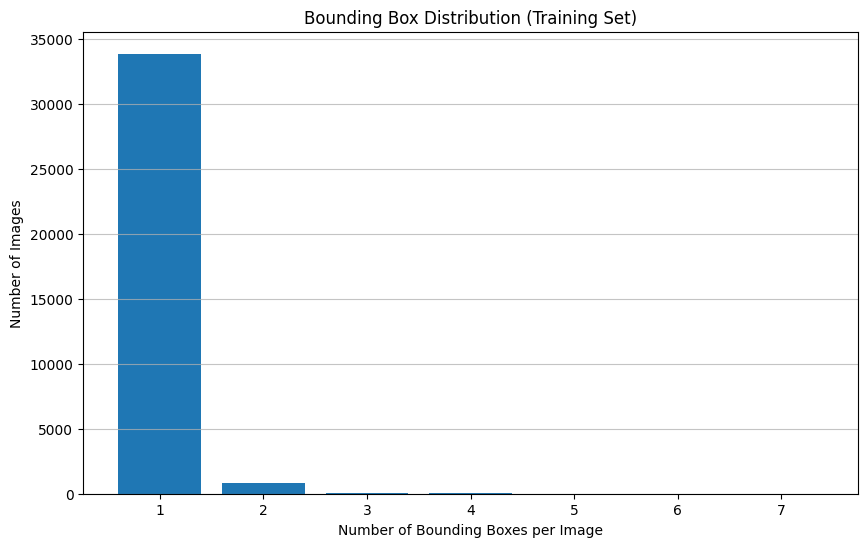

In [ ]:
def plot_bbox_distribution(df, title):
    """
    Plots the distribution of the number of bounding boxes per image.

    Args:
        df: DataFrame containing the annotations.  Must have an 'image_id' column.
        title: Title for the plot.
    """

    # Count the number of bounding boxes per image
    bbox_counts = train_df.groupby('image_id').size().reset_index(name='bbox')
    bbox_distribution = bbox_counts['bbox'].value_counts()

    plt.figure(figsize=(10, 6))
    plt.bar(bbox_distribution.index, bbox_distribution.values)
    plt.xlabel('Number of Bounding Boxes per Image')
    plt.ylabel('Number of Images')
    plt.title(title)
    plt.xticks(bbox_distribution.index)
    plt.grid(axis='y', alpha=0.75)
    plt.show()

plot_bbox_distribution(train_df, "Bounding Box Distribution (Training Set)")

In [ ]:
available_image_filenames = set(os.listdir(image_folder))
train_df = train_df[train_df['image_id'].isin(available_image_filenames)]
test_df = test_df[test_df['image_id'].isin(available_image_filenames)]
val_df = val_df[val_df['image_id'].isin(available_image_filenames)]

print("\nFiltered Train set size:", train_df.shape[0])
print("Filtered Validation set size:", val_df.shape[0])
print("Filtered Test set size:", test_df.shape[0])

print("\nChecking for duplicate image_ids:")
print(f"Images with more than 1 bbox in train_df: {train_df.duplicated(subset=['image_id']).sum()}")
print(f"Images with more than 1 in val_df: {val_df.duplicated(subset=['image_id']).sum()}")
print(f"Images with more than 1 in test_df: {test_df.duplicated(subset=['image_id']).sum()}")

missing_train = [img_id for img_id in train_df['image_id'].unique() if img_id not in available_image_filenames]
missing_val = [img_id for img_id in val_df['image_id'].unique() if img_id not in available_image_filenames]
missing_test = [img_id for img_id in test_df['image_id'].unique() if img_id not in available_image_filenames]

if missing_train or missing_val or missing_test:
    print("WARNING: Missing images after filtering:")
    if missing_train:
        print(f"  {len(missing_train)} image_ids in train_df are missing.")
    if missing_val:
        print(f"  {len(missing_val)} image_ids in val_df are missing.")
    if missing_test:
        print(f"  {len(missing_test)} image_ids in test_df are missing.")
    raise FileNotFoundError("Missing images after filtering. Check data and filtering logic.")



Filtered Train set size: 9849
Filtered Validation set size: 3341
Filtered Test set size: 14

Checking for duplicate image_ids:
Duplicates in train_df: 323
Duplicates in val_df: 58
Duplicates in test_df: 0


### Preparing Dataset for YOLO

In [ ]:
# YOLO Label Creation
def create_yolo_labels(df, output_dir, image_dir, category_mapping):
    os.makedirs(output_dir, exist_ok=True)

    name_to_id = {name: i for i, name in enumerate(sorted(category_mapping.values()))}
    print("YOLO Class Mapping:", name_to_id)

    for image_filename, group in df.groupby('image_id'):
        image_path = os.path.join(image_dir, image_filename)
        try:
            with Image.open(image_path) as img:
                img_width, img_height = img.size
        except (FileNotFoundError, OSError) as e:
            print(f"Error processing image {image_path}: {e}")
            continue

        label_filepath = os.path.join(output_dir, f"{os.path.splitext(image_filename)[0]}.txt")
        with open(label_filepath, 'w') as f:
            for _, row in group.iterrows():
                # Get the YOLO class ID
                yolo_class_id = name_to_id[row['category_name']]

                x_min, y_min, w, h = row['bbox']
                x_center = (x_min + w / 2) / img_width
                y_center = (y_min + h / 2) / img_height
                width = w / img_width
                height = h / img_height
                f.write(f"{yolo_class_id} {x_center} {y_center} {width} {height}\n")

In [ ]:
dataset_root = "/content/datasets/my_custom_dataset"
os.makedirs(dataset_root, exist_ok=True)

train_dir = os.path.join(dataset_root, "train")
val_dir= os.path.join(dataset_root, "val")
test_dir = os.path.join(dataset_root, "test")
train_label_dir = os.path.join(train_dir, "labels")
val_label_dir = os.path.join(val_dir, "labels")
test_label_dir = os.path.join(test_dir, "labels")
train_image_dir = os.path.join(train_dir, "images")
val_image_dir = os.path.join(val_dir, "images")
test_image_dir = os.path.join(test_dir, "images")

In [37]:
os.makedirs(train_label_dir, exist_ok=True)
os.makedirs(val_label_dir, exist_ok=True)
os.makedirs(test_label_dir, exist_ok=True)
os.makedirs(train_image_dir, exist_ok=True)
os.makedirs(val_image_dir, exist_ok=True)
os.makedirs(test_image_dir, exist_ok=True)

In [ ]:
# Create Yolo Variables
create_yolo_labels(train_df, train_label_dir, image_folder, category_mapping)
create_yolo_labels(val_df, val_label_dir, image_folder, category_mapping)
create_yolo_labels(test_df, test_label_dir, image_folder, category_mapping)

YOLO Class Mapping: {'badger': 0, 'bird': 1, 'bobcat': 2, 'car': 3, 'cat': 4, 'coyote': 5, 'deer': 6, 'dog': 7, 'empty': 8, 'fox': 9, 'opossum': 10, 'rabbit': 11, 'raccoon': 12, 'rodent': 13, 'skunk': 14, 'squirrel': 15}
YOLO Class Mapping: {'badger': 0, 'bird': 1, 'bobcat': 2, 'car': 3, 'cat': 4, 'coyote': 5, 'deer': 6, 'dog': 7, 'empty': 8, 'fox': 9, 'opossum': 10, 'rabbit': 11, 'raccoon': 12, 'rodent': 13, 'skunk': 14, 'squirrel': 15}
YOLO Class Mapping: {'badger': 0, 'bird': 1, 'bobcat': 2, 'car': 3, 'cat': 4, 'coyote': 5, 'deer': 6, 'dog': 7, 'empty': 8, 'fox': 9, 'opossum': 10, 'rabbit': 11, 'raccoon': 12, 'rodent': 13, 'skunk': 14, 'squirrel': 15}


In [ ]:
# Move images
train_count = 0
val_count = 0
test_count = 0
for filename in train_df['image_id'].unique():
    src_path = os.path.join(image_folder, filename)
    dst_path = os.path.join(train_image_dir, filename)
    try:
        shutil.copy(src_path, dst_path)
        train_count += 1
    except (FileNotFoundError, Exception) as e:
        print(f"Error copying image {filename}: {e}")

for filename in val_df['image_id'].unique():
    src_path = os.path.join(image_folder, filename)
    dst_path = os.path.join(val_image_dir, filename)
    try:
        shutil.copy(src_path, dst_path)
        val_count += 1
    except (FileNotFoundError, Exception) as e:
        print(f"Error copying image {filename}: {e}")

for filename in test_df['image_id'].unique():
    src_path = os.path.join(image_folder, filename)
    dst_path = os.path.join(test_image_dir, filename)
    try:
        shutil.copy(src_path, dst_path)
        test_count += 1
    except (FileNotFoundError, Exception) as e:
        print(f"Error copying image {filename}: {e}")


In [ ]:
print("\nImage Copying Verification:")
print(f"Successfully copied {train_count} images to the training set.")
print(f"Successfully copied {val_count} images to the validation set.")
print(f"Successfully copied {test_count} images to the test set.")
total_copied = train_count + val_count + test_count
print(f"Total images copied: {total_copied}")


Image Copying Verification:
Successfully copied 9526 images to the training set.
Successfully copied 3283 images to the validation set.
Successfully copied 14 images to the test set.
Total images copied: 12823


In [ ]:
# Create data.yaml
class_names = [name for _, name in sorted(category_mapping.items())]
data_yaml_content = f"""
train: {train_image_dir}
val: {val_image_dir}
test: {test_image_dir}
nc: {len(class_names)}
names: {class_names}
"""
with open("data.yaml", 'w') as f:
    f.write(data_yaml_content)

In [ ]:
transform = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.RandomGamma(gamma_limit=(80, 120), p=0.5),
    A.MotionBlur(blur_limit=(3, 7), p=0.2),
    A.GaussNoise(var_limit=(10.0, 50.0), mean=0, p=0.2),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.Affine(scale=(0.1, 1.9), translate_percent=(-0.2, 0.2), rotate=(-25, 25), shear=(-16, 16), p=0.7),
    ToTensorV2(),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

<ipython-input-42-8736502f53d8>:5: UserWarning: Argument(s) 'var_limit, mean' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), mean=0, p=0.2),


### Model Import and Training

In [ ]:
model = YOLO(r"/content/drive/My Drive/cct20/cct20/my_yolo_project/train17/weights/best.pt")
model.train(data='data.yaml', project=r"/content/drive/My Drive/cct20/cct20/my_yolo_project", imgsz=(747, 1024), batch=-1, epochs=20,augment=True, verbose=True, save=True, box=0.6, iou=0.5, mosaic=0.5)

New https://pypi.org/project/ultralytics/8.3.75 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.103 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/content/drive/My Drive/cct20/cct20/my_yolo_project/train17/weights/best.pt, data=data.yaml, epochs=20, time=None, patience=100, batch=-1, imgsz=(747, 1024), save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/drive/My Drive/cct20/cct20/my_yolo_project, name=train22, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.5, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=F

100%|██████████| 755k/755k [00:00<00:00, 20.8MB/s]



                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics.nn.modules.conv.Conv             [384

100%|██████████| 6.25M/6.25M [00:00<00:00, 110MB/s]


AMP: checks passed ✅
WARNING ⚠️ updating to 'imgsz=1024'. 'train' and 'val' imgsz must be an integer, while 'predict' and 'export' imgsz may be a [h, w] list or an integer, i.e. 'yolo export imgsz=640,480' or 'yolo export imgsz=640'
AutoBatch: Computing optimal batch size for imgsz=1024 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (Tesla T4) 14.74G total, 0.26G reserved, 0.24G allocated, 14.24G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
    25865584       202.5         1.244         58.03         98.64      (1, 3, 1024, 1024)                    list
    25865584       405.1         2.183         51.16          61.3      (2, 3, 1024, 1024)                    list
    25865584       810.1         4.073         98.35         108.9      (4, 3, 1024, 1024)                    list
    25865584        1620         7.686           193         213.6      (8, 3, 1024, 1024)                    list
    25865584   

train: Scanning /content/datasets/my_custom_dataset/train/labels... 9526 images, 0 backgrounds, 138 corrupt: 100%|██████████| 9526/9526 [00:08<00:00, 1063.82it/s]

train: WARNING ⚠️ /content/datasets/my_custom_dataset/train/images/5858c045-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.25        1.25]
train: WARNING ⚠️ /content/datasets/my_custom_dataset/train/images/585a650d-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.25        1.25]
train: WARNING ⚠️ /content/datasets/my_custom_dataset/train/images/585c0351-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1553]
train: WARNING ⚠️ /content/datasets/my_custom_dataset/train/images/585c03aa-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.25        1.25]
train: WARNING ⚠️ /content/datasets/my_custom_dataset/train/images/585da920-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coord

train: New cache created: /content/datasets/my_custom_dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.11/dist-packages/ultralytics/data/augment.py:1837: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /content/datasets/my_custom_dataset/val/labels... 3283 images, 0 backgrounds, 41 corrupt: 100%|██████████| 3283/3283 [00:03<00:00, 967.83it/s] 

val: WARNING ⚠️ /content/datasets/my_custom_dataset/val/images/585a6473-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.25        1.25]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/val/images/585daaa3-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.25        1.25]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/val/images/585f4de6-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.25        1.25]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/val/images/585f5008-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1436]
val: WARNING ⚠️ /content/datasets/my_custom_dataset/val/images/58678c12-23d2-11e8-a6a3-ec086b02610b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0957]

val: New cache created: /content/datasets/my_custom_dataset/val/labels.cache
Plotting labels to /content/drive/My Drive/cct20/cct20/my_yolo_project/train22/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.0005, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 2 dataloader workers
Logging results to /content/drive/My Drive/cct20/cct20/my_yolo_project/train22
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      8.21G    0.09692     0.7144      1.447          4       1024: 100%|██████████| 1174/1174 [13:01<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 203/203 [01:17<00:00,  2.63it/s]

                   all       3242       3299      0.854      0.778      0.811      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      8.54G    0.09799      0.769      1.457          6       1024: 100%|██████████| 1174/1174 [12:59<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 203/203 [01:16<00:00,  2.66it/s]

                   all       3242       3299      0.826      0.753      0.767      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      8.56G    0.09894     0.8275      1.473          5       1024: 100%|██████████| 1174/1174 [12:55<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 203/203 [01:15<00:00,  2.69it/s]

                   all       3242       3299      0.853      0.754      0.778      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      8.54G    0.09775     0.8018      1.456          5       1024: 100%|██████████| 1174/1174 [12:53<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 203/203 [01:15<00:00,  2.69it/s]

                   all       3242       3299      0.826      0.769      0.783      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      8.56G    0.09724     0.7795      1.445          6       1024: 100%|██████████| 1174/1174 [12:53<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 203/203 [01:15<00:00,  2.70it/s]

                   all       3242       3299      0.865      0.723      0.764      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      8.56G    0.09633     0.7602       1.44          6       1024: 100%|██████████| 1174/1174 [12:52<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 203/203 [01:14<00:00,  2.71it/s]

                   all       3242       3299      0.865      0.754      0.785      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      8.56G    0.09572     0.7389       1.43          5       1024: 100%|██████████| 1174/1174 [12:51<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 203/203 [01:14<00:00,  2.71it/s]

                   all       3242       3299      0.798      0.789      0.792      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      8.57G    0.09482     0.7333      1.419          7       1024: 100%|██████████| 1174/1174 [12:53<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 203/203 [01:14<00:00,  2.71it/s]

                   all       3242       3299      0.839      0.777      0.801      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      8.56G    0.09367     0.6976      1.414          7       1024: 100%|██████████| 1174/1174 [12:53<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 203/203 [01:15<00:00,  2.69it/s]

                   all       3242       3299      0.853       0.79      0.807      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      8.57G    0.09273     0.6795      1.407          7       1024: 100%|██████████| 1174/1174 [12:53<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 203/203 [01:15<00:00,  2.69it/s]

                   all       3242       3299      0.858      0.789      0.817      0.549


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.11/dist-packages/ultralytics/data/augment.py:1837: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      8.56G    0.09278     0.5843      1.419          3       1024: 100%|██████████| 1174/1174 [12:52<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 203/203 [01:15<00:00,  2.70it/s]

                   all       3242       3299      0.876      0.806      0.818      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      8.55G    0.09203     0.5651      1.415          4       1024: 100%|██████████| 1174/1174 [12:51<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 203/203 [01:15<00:00,  2.70it/s]

                   all       3242       3299      0.858      0.824      0.814      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      8.56G    0.09088     0.5473      1.388          4       1024: 100%|██████████| 1174/1174 [12:51<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 203/203 [01:14<00:00,  2.71it/s]

                   all       3242       3299       0.87      0.823      0.823      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      8.56G       0.09     0.5347      1.383          4       1024: 100%|██████████| 1174/1174 [12:51<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 203/203 [01:14<00:00,  2.71it/s]

                   all       3242       3299      0.869      0.812      0.831      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      8.57G     0.0885       0.51      1.363          4       1024: 100%|██████████| 1174/1174 [12:49<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 203/203 [01:15<00:00,  2.70it/s]

                   all       3242       3299      0.861      0.821      0.829       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      8.56G    0.08728     0.4907      1.358          8       1024:  96%|█████████▌| 1129/1174 [12:20<00:29,  1.50it/s]